In [ ]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import json
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from ts2vec import TS2Vec


In [ ]:
from utils import load_dataset

# Configurations

In [4]:
config = dict(
    batch_size=2,
    lr=0.001,
    output_dims=1024,
    max_train_length=5000
)

# Useful functions

In [5]:
from sklearn.metrics import accuracy_score

def evaluate(model, X_test, y_test, class_names):
    test_preds = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, test_preds)
    print(f"Accuracy: {accuracy:.4f}")

    print("Test Classification Report:")
    print(classification_report(y_test, test_preds, labels=[0, 1, 4], digits=4))

    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, test_preds))

    # ROC Curve
    y_score = model.predict_proba(X_test)
    plt.figure()

    # Confusion Matrix
    print("Confusion Matrix (Test):")
    cm = confusion_matrix(y_test, test_preds)
    print(cm)
    
    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    plt.figure()
    for i in range(len(np.unique(y_test))):
        fpr, tpr, _ = roc_curve([1 if y == i else 0 for y in y_test], y_score[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (area = {roc_auc_score([1 if y == i else 0 for y in y_test], y_score[:, i]):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [6]:
def load_files(files, labels, max_len=5000):
    data_arr = []
    final_labels = []
    
    for filepath, label in zip(files, labels):
        df = pd.read_csv(filepath)
        x = df['time'].astype(np.float32).values

        if len(x) == 0:
            print(f"File {filepath} is empty.")
            continue

        start = 0.05 * len(x)
        end = 0.95 * len(x)
        x = x[int(start):int(end)]

        if max_len is not None:
            if len(x) > max_len:
                x = x[:max_len]
            if len(x) < max_len:
                x = np.pad(x, (0, max_len - len(x)), 'constant', constant_values=(0))

        # x = np.expand_dims(x, axis=1)

        # cdf = calculate_cdf(x)
        x = np.expand_dims(x, axis=1)

        data_arr.append(x)
        final_labels.append(label)
    
    return np.array(data_arr), np.array(final_labels)

In [7]:
def get_data(data_files):
    files = []
    labels = []

    for operator in data_files:
        files.extend(data_files[operator]['files'])
        labels.extend([data_files[operator]['label']]*len(data_files[operator]['files']))


    data, labels = load_files(files, labels)

    return data, labels

# Load datasets

In [8]:
nexmark_dataset = load_dataset.load_nexmark_data(is_split=False)
nexmark_data, nexmark_labels = get_data(nexmark_dataset)

File ./nexmark_dataset/q2_filter/tail_0_292_filter_bidder_is_not_divisible_by_sum_of_field_moduli.csv is empty.
File ./nexmark_dataset/q6_filter/tail_0_292_filter_bidder_is_not_divisible_by_sum_of_field_moduli+292_filter_category_times_id_plus_seller_mod_duration_is_less_than_initialBid.csv is empty.


In [9]:
secure_sgx_dataset = load_dataset.load_secure_sgx_data(is_split=False)
secure_sgx_data, secure_sgx_labels = get_data(secure_sgx_dataset)

# Load model and embeddings

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = TS2Vec(
    input_dims=1,
    device=device,
    **config
)

model.load(f'models/ts2vec_model_5000_1024.pkl')

In [11]:
nexmark_embeddings = model.encode(nexmark_data, encoding_window='full_series')
secure_sgx_embeddings = model.encode(secure_sgx_data, encoding_window='full_series')

# Random Forest

In [ ]:
rf_nexmark = joblib.load('models/rf_grid_nexmark.pkl')
rf_nexmark.best_params_

/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.6

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 250}

Accuracy: 0.4856
Test Classification Report:
              precision    recall  f1-score   support

           0     0.7294    0.8368    0.7794       380
           1     0.7898    0.6619    0.7202       352
           4     0.0000    0.0000    0.0000         0

   micro avg     0.5135    0.7527    0.6105       732
   macro avg     0.5064    0.4996    0.4999       732
weighted avg     0.7584    0.7527    0.7510       732

Confusion Matrix (Test):
[[318  62   0   0   0   0   0]
 [118 233   1   0   0   0   0]
 [  0   0  39  63 342   1  38]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
Confusion Matrix (Test):
[[318  62   0   0   0   0   0]
 [118 233   1   0   0   0   0]
 [  0   0  39  63 342   1  38]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]


/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<Figure size 640x480 with 0 Axes>

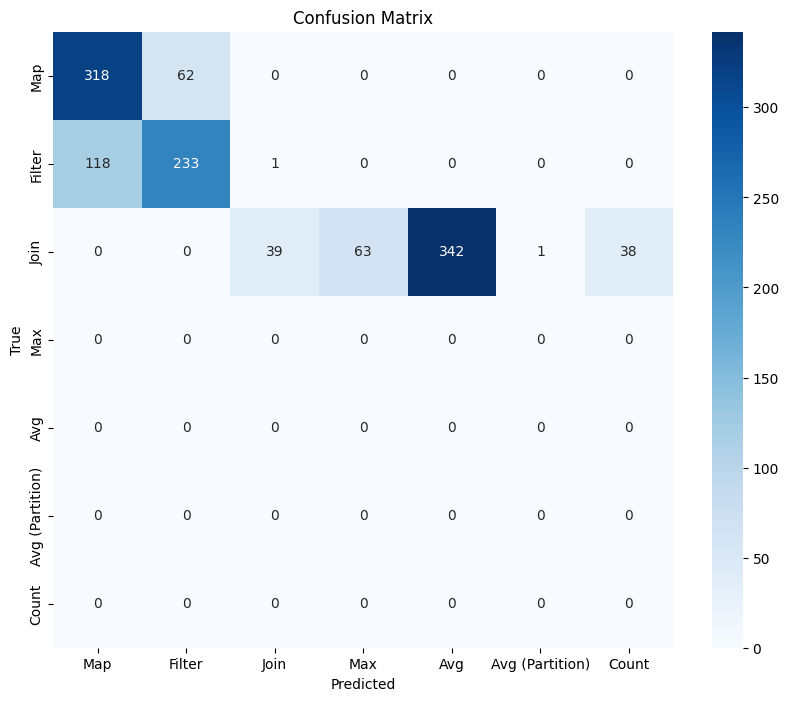

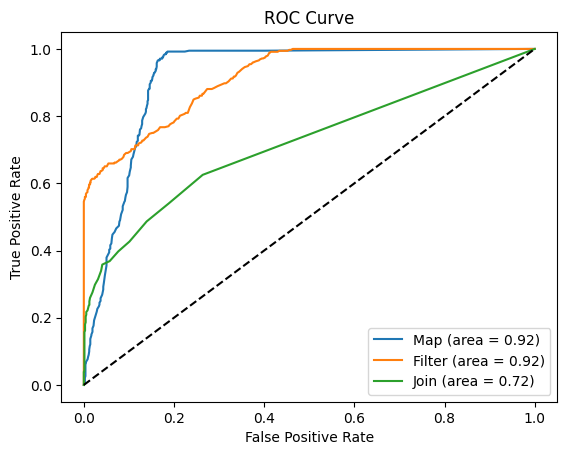

In [14]:
rf = RandomForestClassifier(**rf_nexmark.best_params_, n_jobs=-1, random_state=42)
rf.fit(nexmark_embeddings, nexmark_labels)
evaluate(rf, secure_sgx_embeddings, secure_sgx_labels, load_dataset.NEXMARK_CLASS_NAMES)

# SVM

In [ ]:
svr_nexmark = joblib.load('models/svr_grid_nexmark.pkl')
svr_nexmark.best_params_

/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.6.1 when using version 1.7.2. Th

{'svc__C': 100, 'svc__gamma': 1, 'svc__kernel': 'rbf'}

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Define pipeline: scaler + SVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=100, gamma=1, kernel='rbf'))
])

pipeline.fit(nexmark_embeddings, nexmark_labels)
evaluate(pipeline, secure_sgx_embeddings, secure_sgx_labels, load_dataset.NEXMARK_CLASS_NAMES)

Accuracy: 0.4255
Test Classification Report:
              precision    recall  f1-score   support

           0     0.7132    0.4842    0.5768       380
           1     0.5853    0.7898    0.6723       352
           4     0.0000    0.0000    0.0000         0

   micro avg     0.4189    0.6311    0.5035       732
   macro avg     0.4328    0.4247    0.4164       732
weighted avg     0.6517    0.6311    0.6227       732

Confusion Matrix (Test):
[[184 196   0   0   0   0]
 [ 74 278   0   0   0   0]
 [  0   1  55  43 370  14]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]]


/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


AttributeError: This 'Pipeline' has no attribute 'predict_proba'

# XGB

In [ ]:
xgb_nexmark = joblib.load('models/xgb_grid_nexmark.pkl')
xgb_nexmark.best_params_

/home/bkcs/miniforge3/lib/python3.12/pickle.py:1760: UserWarning: [10:04:24] WARNING: /workspace/src/collective/../data/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


{'gamma': 0, 'max_depth': 3, 'n_estimators': 150}

/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:04:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.4905
Test Classification Report:
              precision    recall  f1-score   support

           0     0.7327    0.7789    0.7551       380
           1     0.7439    0.6932    0.7176       352
           4     0.0000    0.0000    0.0000         0

   micro avg     0.5109    0.7377    0.6037       732
   macro avg     0.4922    0.4907    0.4909       732
weighted avg     0.7381    0.7377    0.7371       732

Confusion Matrix (Test):
[[296  84   0   0   0   0]
 [108 244   0   0   0   0]
 [  0   0  56  54 325  48]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]]
Confusion Matrix (Test):
[[296  84   0   0   0   0]
 [108 244   0   0   0   0]
 [  0   0  56  54 325  48]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]]


/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<Figure size 640x480 with 0 Axes>

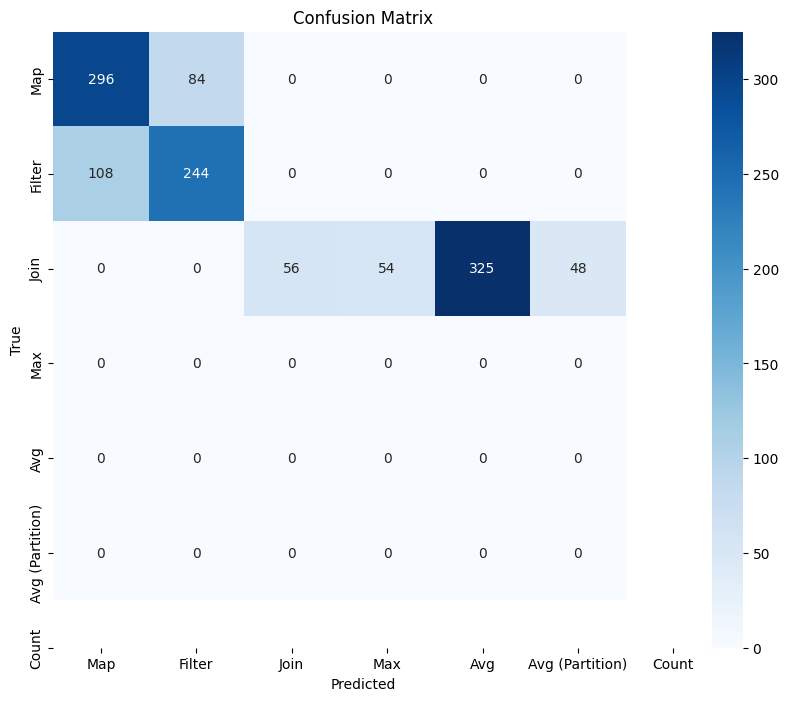

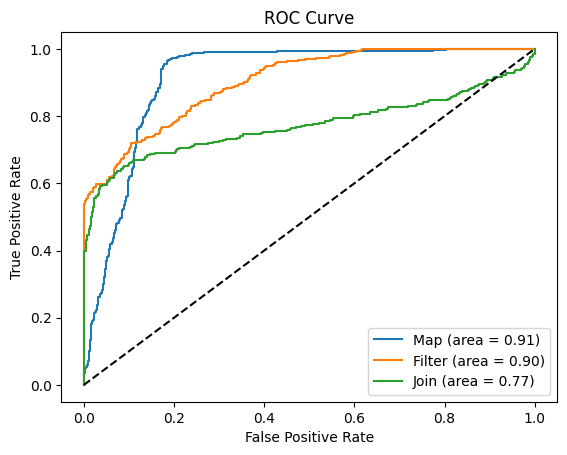

In [18]:
from xgboost import XGBClassifier

xgb = XGBClassifier(**xgb_nexmark.best_params_, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(nexmark_embeddings, nexmark_labels)
evaluate(xgb, secure_sgx_embeddings, secure_sgx_labels, load_dataset.NEXMARK_CLASS_NAMES)